# Training a Torch NN-regression model 
### *Key implementations:* MinMax-Scaling of target data, initial weights, date-normalization

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Retrieving data names from specified path
path = '/Users/jeppegrejspetersen/Code/Final_project_AppML/era5'
input_files_msl = [f for f in os.listdir(path) if f.endswith('.nc') and 'mean_sea_level_pressure' in f]

# Sorting the file names based on the year extracted from the filename
input_files_msl.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Displaying the sorted list of file names
for file in input_files_msl:
    print(file)

era5_1940_mean_sea_level_pressure.nc
era5_1941_mean_sea_level_pressure.nc
era5_1942_mean_sea_level_pressure.nc
era5_1943_mean_sea_level_pressure.nc
era5_1944_mean_sea_level_pressure.nc


In [4]:
##merge the files from the list
file_paths_msl = [os.path.join(path, fname) for fname in input_files_msl]

# Then open all files with xarray
ds_msl = xr.open_mfdataset(file_paths_msl, combine='by_coords').sel(latitude=slice(70, 40.25), longitude=slice(-80, 21.75))

doy = ds_msl['valid_time'].dt.dayofyear
ds_msl = ds_msl.assign_coords(day_of_year=doy) ## 28 feb is 366. i have 2 of these in the 5 years.


def standard_scale_day(group, eps = 1e-6):
    mean_val = group.mean(dim='valid_time')
    std_val = group.std(dim='valid_time') + eps
    return (group - mean_val) / std_val

msl_stand = ds_msl['msl'].groupby('day_of_year').map(standard_scale_day)
ds_msl['msl_stand'] = msl_stand


['era5_1940_temperature_850hPa.nc', 'era5_1941_temperature_850hPa.nc', 'era5_1942_temperature_850hPa.nc', 'era5_1943_temperature_850hPa.nc', 'era5_1944_temperature_850hPa.nc']


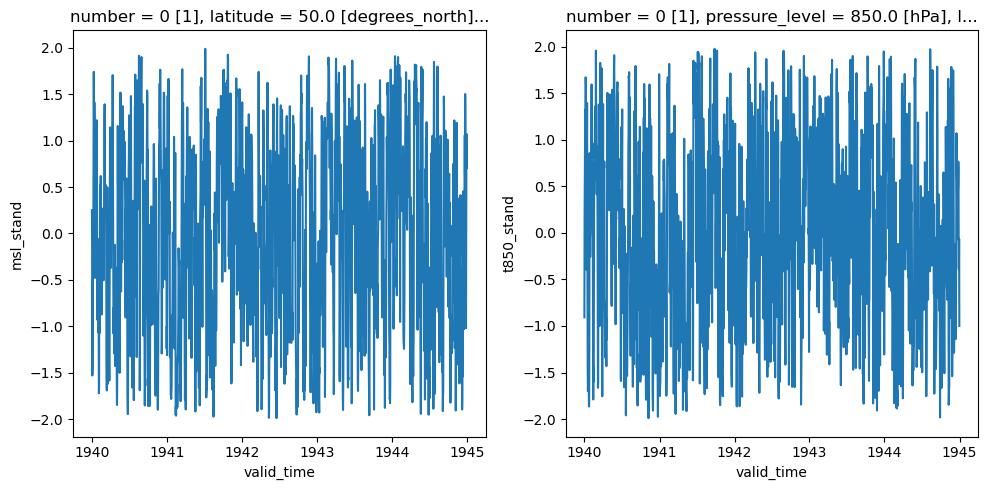

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ds_msl.msl_stand.sel(longitude=0, latitude=50, method = 'nearest').plot(ax=ax[0])

input_files_t850 = [f for f in os.listdir(path) if f.endswith('.nc') and '850' in f]
input_files_t850.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
print(input_files_t850)

file_paths_t850 = [os.path.join(path, fname) for fname in input_files_t850]
ds_t850 = xr.open_mfdataset(file_paths_t850, combine='by_coords').isel(pressure_level=0).sel(latitude=slice(70, 40.25), longitude=slice(-80, 21.75))

doy_t850 = ds_t850['valid_time'].dt.dayofyear
ds_t850 = ds_t850.assign_coords(day_of_year=doy_t850)
t850_stand = ds_t850['t'].groupby('day_of_year').map(standard_scale_day)
ds_t850['t850_stand'] = t850_stand
ds_t850.t850_stand.sel(longitude=0, latitude=50, method = 'nearest').plot(ax=ax[1])
plt.tight_layout()

In [6]:
## cehck for nan in the msl-data
msl_input = ds_msl.msl_stand.values
print('NaNs present?:', np.isnan(msl_input).any(),'\n',
      'Data shape', msl_input.shape, '\n',)


t850_input = ds_t850.t850_stand.values

## check for nan in the t850-data
print('NaNs present?:', np.isnan(t850_input).any(),'\n',
      'Data shape', t850_input.shape, '\n',)

NaNs present?: False 
 Data shape (1827, 120, 408) 

NaNs present?: False 
 Data shape (1827, 120, 408) 



(1827,)

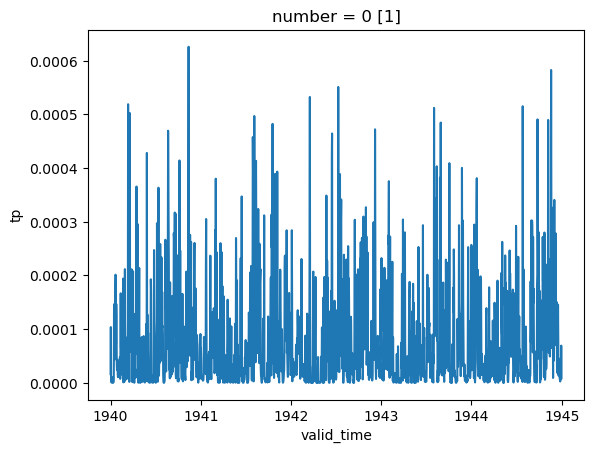

In [7]:
# Retriving percipitation data file names and sorting based on year
target_prec = [f for f in os.listdir(path) if f.endswith('.nc') and 'total' in f]
target_prec.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))


# Importing precipitation data
file_paths_prec = [os.path.join(path, fname) for fname in target_prec]
ds_prec = xr.open_mfdataset(file_paths_prec, combine='by_coords')

# Calculating the mean across the spatial dimensions (longitude and latitude)
ds_prec = ds_prec.mean(dim= ['longitude', 'latitude'])
prec_target = ds_prec.tp.values
ds_prec.tp.plot()
prec_target.shape

In [8]:
import sys 

import torch
import torch.optim as optim
import torch.nn as nn
from torchinfo import summary
from torcheval.metrics.functional import binary_f1_score
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# import preprocessing as prep
# import postprocessing as post
# import training as train
# import models as mod
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
import pickle
from torch.utils.data import TensorDataset, DataLoader



In [9]:
X = np.stack([t850_input, msl_input], axis=1)
print('X shape:', X.shape)

def sample_data(X, n):
    """
    A function to sample data from a 4D array X with shape (time, variable, x, y).
    The function samples every n-th element along the spatial dimension (x, y),
    reshapes the sampled data into n parts, and returns a new xarray Dataset or DataArray,
    containing a concatenated list of the n parts.

    Parameters:
    X (np.ndarray): Input data with shape (time, variable, x, y).
    n (int): The factor by which to sample the spatial dimensions.

    Returns:
    xr.Dataset or xr.DataArray: A new xarray object containing the sampled and reshaped data.

    Notes:
    - Sampling of data has been scrapped, as the impact on the model performance was very negative.

    """
    t, v, x, y = X.shape
    X_flat = X.reshape(t, v, x * y)

    # Sample every n-th element along the last dimension
    sampled_X = X_flat[:, :, ::n]

    # Split the sampled data into n parts along the last dimension
    split_X = np.array_split(sampled_X, n, axis=2)
    

    # Reshaping into (t, v, x, y) format    new_x, new_y = x // n, y // n
    new_x = x // n
    new_y = y // n

    result_datasets = []
    for i, part in enumerate(split_X):
        reshaped = part.reshape(t, v, new_x, new_y)
        # Create an xarray Dataset or DataArray from this
        da = xr.DataArray(reshaped, dims=('time', 'variable', 'x', 'y'))
        result_datasets.append(da)

    # Concatenate the datasets along time dimension
    result_datasets = xr.concat(result_datasets, dim='time')
    return result_datasets


#### RUN IF SAMPLING IS DESIRED ####

## Sample the data with n=4
# sample_X = sample_data(X, 4)
# X = sample_X

## copy prec_target 4 times and concatenate along the time dimension
# prec_target_concat = np.repeat(prec_target, 4, axis=0)
# print(prec_target_concat.shape) # Add a new dimension for 'x'
# prec_target = prec_target_concat

####################################

X shape: (1827, 2, 120, 408)


In [10]:
from sklearn.preprocessing import MinMaxScaler

#take 250 random samples from X to test the model
test_size = 250
random_indices = np.random.choice(X.shape[0], size=test_size, replace=False)
# Create a boolean mask for test data
mask = np.zeros(X.shape[0], dtype=bool)
mask[random_indices] = True

# Split the data using the mask
X_test = X[mask]
X_train = X[~mask]
scaler = MinMaxScaler()

y_test = scaler.fit_transform(prec_target[mask].reshape(-1, 1))
y_train =scaler.transform(prec_target[~mask].reshape(-1, 1))

# Check the shapes
print('Original data:', X.shape)
print('X_train data:', X_train.shape)
print('y_train data:', y_train.shape)
print('X_test data:', X_test.shape)
print('y_test data:', y_test.shape)

input_shape = X_train.shape[2:]
print(input_shape)

Original data: (1827, 2, 120, 408)
X_train data: (1577, 2, 120, 408)
y_train data: (1577, 1)
X_test data: (250, 2, 120, 408)
y_test data: (250, 1)
(120, 408)


In [11]:
X_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train)
print('X-tensor shape:', X_tensor.shape, 'Y-tensor shape:', y_tensor.shape)


X = X_tensor.view(X_train.shape[0], -1)
y = y_tensor.view(y_train.shape[0], 1)
print('X-tensor new shape:', X.shape, 'Y-tensor new shape:', y.shape)

# Create dataset
dataset = TensorDataset(X, y)


X-tensor shape: torch.Size([1577, 2, 120, 408]) Y-tensor shape: torch.Size([1577, 1])
X-tensor new shape: torch.Size([1577, 97920]) Y-tensor new shape: torch.Size([1577, 1])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()

        hidden_dims = [2048, 1024, 512, 256]

        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            linear_layer = nn.Linear(prev_dim, hdim)
            # Initialize weights using Xavier normal
            nn.init.xavier_normal_(linear_layer.weight)
            nn.init.zeros_(linear_layer.bias)
            
            layers.append(linear_layer)
            layers.append(nn.BatchNorm1d(hdim)) 
            layers.append(nn.ELU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        # Final output layer with Xavier initialization
        final_layer = nn.Linear(prev_dim, 1)
        nn.init.xavier_normal_(final_layer.weight)
        nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Model setup
input_dim = input_shape[0] * input_shape[1] *2

model = FFNN(input_dim)

In [13]:
# Print model summary
summary(model, input_size=(1, input_dim), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
FFNN                                     [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 2048]                 200,542,208
│    └─BatchNorm1d: 2-2                  [1, 2048]                 4,096
│    └─ELU: 2-3                          [1, 2048]                 --
│    └─Dropout: 2-4                      [1, 2048]                 --
│    └─Linear: 2-5                       [1, 1024]                 2,098,176
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─ELU: 2-7                          [1, 1024]                 --
│    └─Dropout: 2-8                      [1, 1024]                 --
│    └─Linear: 2-9                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024
│    └─ELU: 2-11                         [1, 512]      

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, random_split


# Data split (already good)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Loss, optimizer, and scheduler
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:            
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= val_size

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:  # small threshold for improvement
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # optional: save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break


Epoch 1/100 — Train Loss: 0.3352 — Val Loss: 0.3001
Epoch 11/100 — Train Loss: 0.1544 — Val Loss: 0.2011
Epoch 21/100 — Train Loss: 0.1135 — Val Loss: 0.1497
Epoch 31/100 — Train Loss: 0.0845 — Val Loss: 0.1096
Epoch 41/100 — Train Loss: 0.0672 — Val Loss: 0.0994
Early stopping triggered.


Mean Squared Error: 0.0186


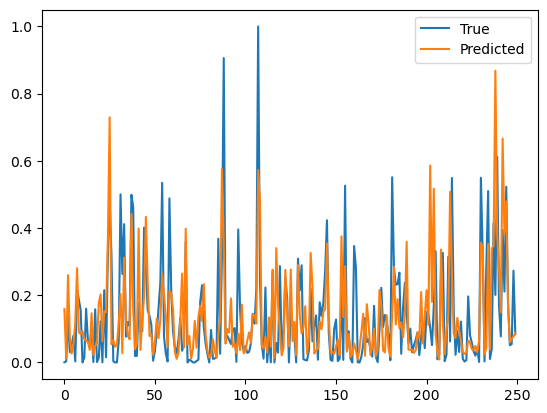

In [16]:
plt.plot(y_test, label='True')

y_pred = model(torch.from_numpy(X_test).view(test_size, -1)).detach().numpy()
mse = np.mean((y_pred - y_test) ** 2)
print(f'Mean Squared Error: {mse:.4f}')
plt.plot(y_pred, label='Predicted')
plt.legend()

____

## LRP on the NN model

In [19]:
og_shape = X_test.shape
input_tensor = torch.from_numpy(X_test).view(test_size, -1)

import sys
sys.path.append('/Users/jeppegrejspetersen/Code/Final_project_AppML/LRP_ERA5_fork/niels')
import LRP_calc as qlrp
import LRP_plotter as plrp
attributions, attr_sum = qlrp.lrp_calc(model, input_tensor, og_shape)
# fig_lrp, ax_lrp = plrp.plot_LRP(attr_sum)
print(attr_sum.shape)

(2, 120, 408)


In [20]:
def normalize_lrp(lrp_maps):
    
    global_max = max(
        np.abs(lrp_maps[0]).max(),
        np.abs(lrp_maps[1]).max()
    )

    return lrp_maps / global_max  # scales to [-1, 1] if global_max is abs-max


In [21]:
attr_sum = normalize_lrp(attr_sum)


In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

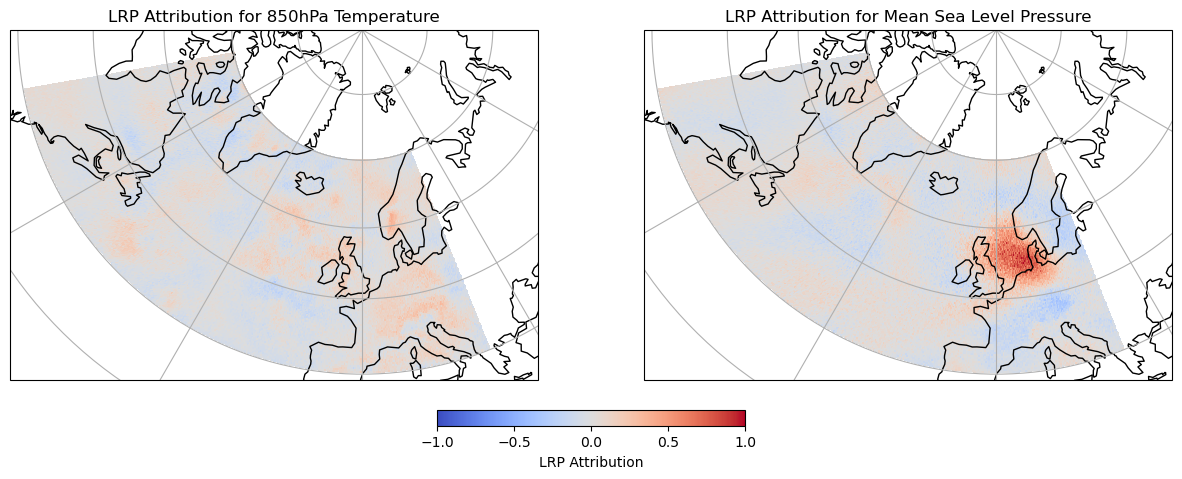

In [34]:
fig, axs = plt.subplots(ncols=2,nrows=1, figsize=(15, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for ax in axs.flatten():
    ax.coastlines()
    # ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.gridlines()

    ax.set_extent([-90, 30, 39, 90], ccrs.PlateCarree())


axs[0].set_title('LRP Attribution for 850hPa Temperature')
cbar = axs[0].pcolormesh(ds_msl.longitude, ds_msl.latitude, attr_sum[0], cmap='coolwarm', transform=ccrs.PlateCarree(), 
                  vmin = -1, vmax = 1)

axs[1].set_title('LRP Attribution for Mean Sea Level Pressure')
axs[1].pcolormesh(ds_msl.longitude, ds_msl.latitude, attr_sum[1], cmap='coolwarm', transform=ccrs.PlateCarree(),
                  vmin = -1, vmax = 1)
## make colorbar
fig.colorbar(cbar, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04, label='LRP Attribution')
